In [ ]:
import os
import zipfile
import gdown
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from google.colab import files

In [ ]:
# Ganti dengan ID file Anda
file_id = '1b9WJpb6cnDhfDuVUqZwBtmkFe6XtU2r4'
url = f'https://drive.google.com/uc?id={file_id}'

# Lokasi tempat menyimpan file zip yang diunduh
zip_path = '/content/mushroom_dataset.zip'

# Mengunduh file
gdown.download(url, zip_path, quiet=False)

# Ekstrak file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/my_folder')

Downloading...
From (original): https://drive.google.com/uc?id=1b9WJpb6cnDhfDuVUqZwBtmkFe6XtU2r4
From (redirected): https://drive.google.com/uc?id=1b9WJpb6cnDhfDuVUqZwBtmkFe6XtU2r4&confirm=t&uuid=020a86f2-8e0d-4add-9562-78d3fe3ed7c7
To: /content/mushroom_dataset.zip
100%|██████████| 425M/425M [00:04<00:00, 96.0MB/s]


In [ ]:
# Direktori dataset
base_dir = '/content/my_folder/mushroom_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Kelas
edible_classes = [
    'Ganoderma applanatum',
    'Ganoderma oregonense',
    'Coprinellus micaceus',
    'Coprinus comatus',
    'Amanita amerirubescens',
    'Amanita calyptroderma',
    'Armillaria mellea',
    'Clitocybe nuda',
    'Flammulina velutipes',
    'Boletus rex-veris'
]

non_edible_classes = [
    'Coprinopsis lagopus',
    'Crucibulum laeve',
    'Ganoderma curtisii',
    'Ganoderma tsugae',
    'Hypholoma lateritium',
    'Leucoagaricus americanus',
    'Leucoagaricus leucothites',
    'Mycena leaiana',
    'Panellus stipticus',
    'Schizophyllum commune'
]

def get_edibility_label(class_name):
    if class_name in edible_classes:
        return 0  # Edible
    elif class_name in non_edible_classes:
        return 1  # Non-edible
    else:
        raise ValueError(f"Unknown class name: {class_name}")

In [ ]:
# Base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = True

# Freeze layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
mushroom_class_output = Dense(len(edible_classes) + len(non_edible_classes), activation='softmax', name='mushroom_class_output')(x)
edibility_output = Dense(2, activation='softmax', name='edibility_output')(x)

model = Model(inputs=base_model.input, outputs=[mushroom_class_output, edibility_output])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'mushroom_class_output': 'categorical_crossentropy', 'edibility_output': 'categorical_crossentropy'},
              metrics={'mushroom_class_output': 'accuracy', 'edibility_output': 'accuracy'})

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

def custom_generator(generator):
    class_indices = generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}

    while True:
        x, y = generator.next()
        batch_size = x.shape[0]
        edibility_labels = np.array([get_edibility_label(index_to_class[np.argmax(y[i])])
                                     for i in range(batch_size)])
        edibility_labels = tf.keras.utils.to_categorical(edibility_labels, num_classes=2)
        yield x, {'edibility_output': edibility_labels, 'mushroom_class_output': y}

train_generator_custom = custom_generator(train_generator)
validation_generator_custom = custom_generator(validation_generator)

Found 4815 images belonging to 20 classes.
Found 1250 images belonging to 20 classes.


In [ ]:
# Train model
history = model.fit(
    train_generator_custom,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator_custom,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/25
75/75 [==============================] - 173s 2s/step - loss: 2.7092 - mushroom_class_output_loss: 2.0437 - edibility_output_loss: 0.6655 - mushroom_class_output_accuracy: 0.4288 - edibility_output_accuracy: 0.7221 - val_loss: 1.9222 - val_mushroom_class_output_loss: 1.5092 - val_edibility_output_loss: 0.4130 - val_mushroom_class_output_accuracy: 0.5979 - val_edibility_output_accuracy: 0.8257
Epoch 2/25
75/75 [==============================] - 139s 2s/step - loss: 1.2399 - mushroom_class_output_loss: 0.8677 - edibility_output_loss: 0.3721 - mushroom_class_output_accuracy: 0.7300 - edibility_output_accuracy: 0.8474 - val_loss: 0.9429 - val_mushroom_class_output_loss: 0.6998 - val_edibility_output_loss: 0.2430 - val_mushroom_class_output_accuracy: 0.8280 - val_edibility_output_accuracy: 0.9098
Epoch 3/25
75/75 [==============================] - 128s 2s/step - loss: 0.7987 - mushroom_class_output_loss: 0.5394 - edibility_output_loss: 0.2594 - mushroom_class_output_accuracy: 0.8

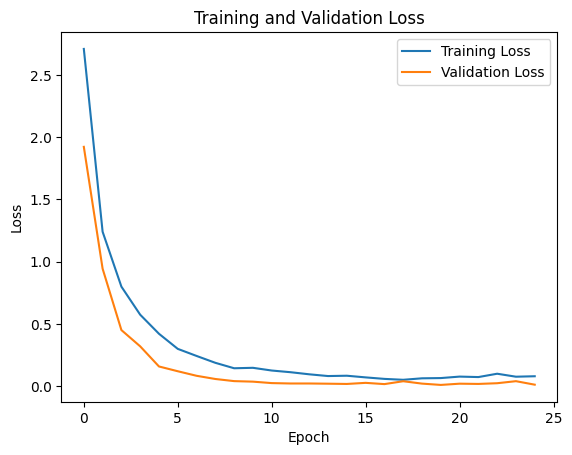

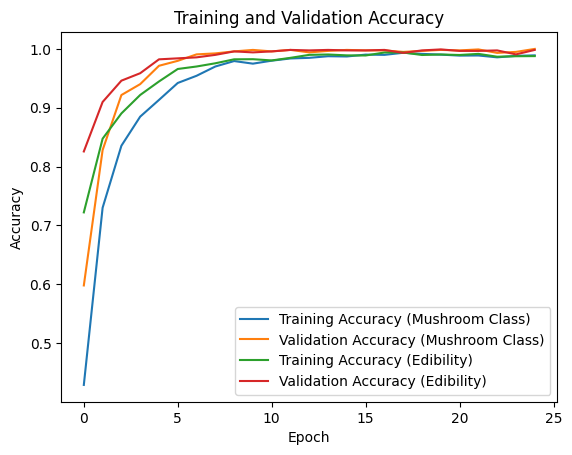

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['mushroom_class_output_accuracy'], label='Training Accuracy (Mushroom Class)')
    plt.plot(history.history['val_mushroom_class_output_accuracy'], label='Validation Accuracy (Mushroom Class)')
    plt.plot(history.history['edibility_output_accuracy'], label='Training Accuracy (Edibility)')
    plt.plot(history.history['val_edibility_output_accuracy'], label='Validation Accuracy (Edibility)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
# Evaluate model
loss, mushroom_class_output_loss, edibility_output_loss, mushroom_class_output_accuracy, edibility_output_accuracy = model.evaluate(
    validation_generator_custom,
    steps=validation_generator.samples // validation_generator.batch_size
)

print(f"Validation loss: {loss}")
print(f"Validation mushroom class output loss: {mushroom_class_output_loss}")
print(f"Validation edibility output loss: {edibility_output_loss}")
print(f"Validation mushroom class output accuracy: {mushroom_class_output_accuracy}")
print(f"Validation edibility output accuracy: {edibility_output_accuracy}")

19/19 [==============================] - 6s 335ms/step - loss: 0.0107 - mushroom_class_output_loss: 0.0025 - edibility_output_loss: 0.0082 - mushroom_class_output_accuracy: 1.0000 - edibility_output_accuracy: 0.9983
Validation loss: 0.01068171113729477
Validation mushroom class output loss: 0.0025259044487029314
Validation edibility output loss: 0.008155807852745056
Validation mushroom class output accuracy: 1.0
Validation edibility output accuracy: 0.9983136653900146


In [ ]:
# Additional metrics
y_true_class = []
y_true_edibility = []
y_pred_class = []
y_pred_edibility = []

validation_generator.reset()
for _ in range(validation_generator.samples // validation_generator.batch_size):
    x, y = next(validation_generator_custom)
    y_true_class.extend(np.argmax(y['mushroom_class_output'], axis=1))
    y_true_edibility.extend(np.argmax(y['edibility_output'], axis=1))
    predictions = model.predict(x)
    y_pred_class.extend(np.argmax(predictions[0], axis=1))
    y_pred_edibility.extend(np.argmax(predictions[1], axis=1))

# Evaluation for mushroom class classification
precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(y_true_class, y_pred_class, average='macro')
accuracy_class = accuracy_score(y_true_class, y_pred_class)

print("Metrics for mushroom class classification:")
print(f'Precision: {precision_class}')
print(f'Recall: {recall_class}')
print(f'F1 Score: {f1_class}')
print(f'Accuracy: {accuracy_class}')

# Evaluation for edibility classification
precision_edibility, recall_edibility, f1_edibility, _ = precision_recall_fscore_support(y_true_edibility, y_pred_edibility, average='macro')
accuracy_edibility = accuracy_score(y_true_edibility, y_pred_edibility)

print("Metrics for edibility classification:")
print(f'Precision: {precision_edibility}')
print(f'Recall: {recall_edibility}')
print(f'F1 Score: {f1_edibility}')
print(f'Accuracy: {accuracy_edibility}')

2/2 [==============================] - 0s 123ms/step
Metrics for mushroom class classification:
Precision: 0.9992424242424243
Recall: 0.9992307692307693
F1 Score: 0.9992307237114624
Accuracy: 0.9991776315789473
Metrics for edibility classification:
Precision: 0.9982394366197183
Recall: 0.9984615384615385
F1 Score: 0.9983477497601791
Accuracy: 0.9983552631578947


In [ ]:
# Save model
model.save('/content/my_folder/model.keras')
print("Keras model saved as model.keras")

Keras model saved as model.h5


In [ ]:
# Convert to TFLite model
model = tf.keras.models.load_model('/content/my_folder/model.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/my_folder/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model TFLite saved as model.tflite")

In [ ]:
# Download the TFLite model
files.download(tflite_model)  # This will download the file 'model.tflite'

# "Error: Invalid class index"

In [ ]:
# Fungsi untuk memuat gambar
def load_image(image_path, target_size=(299, 299)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Fungsi untuk prediksi gambar
def predict_image(model_path, image_path, edible_class_names, non_edible_class_names):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = load_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    class_output = interpreter.get_tensor(output_details[0]['index'])
    edibility_output = interpreter.get_tensor(output_details[1]['index'])

    edibility_index = np.argmax(edibility_output)
    edibility = 'Edible' if edibility_index == 0 else 'Non-Edible'

    class_index = np.argmax(class_output)

    if edibility == 'Edible':
        if class_index < len(edible_class_names):
            mushroom_class = edible_class_names[class_index]
        else:
            mushroom_class = "Unknown edible class"
    else:
        if class_index < len(non_edible_class_names):
            mushroom_class = non_edible_class_names[class_index]
        else:
            mushroom_class = "Unknown non-edible class"

    return mushroom_class, edibility

# Fungsi untuk mengunggah dan memprediksi gambar
def upload_and_predict():
    uploaded = files.upload()

    for fn in uploaded.keys():
        path = '/content/' + fn
        mushroom_class, edibility = predict_image('/content/my_folder/model.tflite', path, edible_classes, non_edible_classes)
        print(f'{fn} is classified as {mushroom_class} ({edibility})')

upload_and_predict()

# "Unknown edible class" / "Unknown non-edible class"

In [ ]:
# Fungsi untuk memuat gambar
def load_image(image_path, target_size=(299, 299)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Fungsi untuk prediksi gambar
def predict_image(model_path, image_path, edible_class_names, non_edible_class_names):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = load_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    class_output = interpreter.get_tensor(output_details[0]['index'])
    edibility_output = interpreter.get_tensor(output_details[1]['index'])

    edibility_index = np.argmax(edibility_output)
    edibility = 'Edible' if edibility_index == 0 else 'Non-Edible'

    class_index = np.argmax(class_output)

    print(f"Predicted class index: {class_index}, Edibility index: {edibility_index}")

    if edibility == 'Edible':
        if class_index < len(edible_class_names):
            mushroom_class = edible_class_names[class_index]
        else:
            mushroom_class = "Unknown edible class"
    else:
        if class_index < len(non_edible_class_names):
            mushroom_class = non_edible_class_names[class_index]
        else:
            mushroom_class = "Unknown non-edible class"

    return mushroom_class, edibility

# Fungsi untuk mengunggah dan memprediksi gambar
def upload_and_predict():
    uploaded = files.upload()

    for fn in uploaded.keys():
        path = '/content/' + fn
        mushroom_class, edibility = predict_image('/content/my_folder/model.tflite', path, edible_classes, non_edible_classes)
        print(f'{fn} is classified as {mushroom_class} ({edibility})')

upload_and_predict()
